# CAB420, DCNNs, Additional Example 0: Deep Learning Motivation
Dr Simon Denman (s.denman@qut.edu.au)

## Overview
This example will briefly look why we need feature extraction when training machine learning models with many data types, and consider how this motivates the of Deep Learning methods.

This example borrows somewhat heavily from a bonus example from the previous topic (02_Classification/CAB420_Classification_Bonus_Example_HOG.ipynb), in that we're using the same feature extraction that was demonstrated there. I'm not going to go through the HOG feature extraction here in deatil - this is somewhat tangential to CAB420 - but if you are interested please go and have a look at the bonus example.

The model used in this example is just a simple random forest. It's not optimal, but it shows what we need to see for the purposes of this example.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import hog, local_binary_pattern
from skimage import data, exposure
from sklearn.metrics import ConfusionMatrixDisplay
import keras as keras

E0000 00:00:1738192665.709386   54872 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738192665.713413   54872 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## The Data

We'll use an image dataset here. This is the [imagenette dataset](https://github.com/fastai/imagenette), a cut down of ImageNet suitable for small scale tests. It contains 10 different types of things, and has about ~10,000 training images. 

The code in this block is taken from the earlier mentioned bonus example (02_Classification/CAB420_Classification_Bonus_Example_HOG.ipynb). 

I0000 00:00:1738192668.347992   54872 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1880 MB memory:  -> device: 0, name: NVIDIA A16-4Q, pci bus id: 0000:02:07.0, compute capability: 8.6


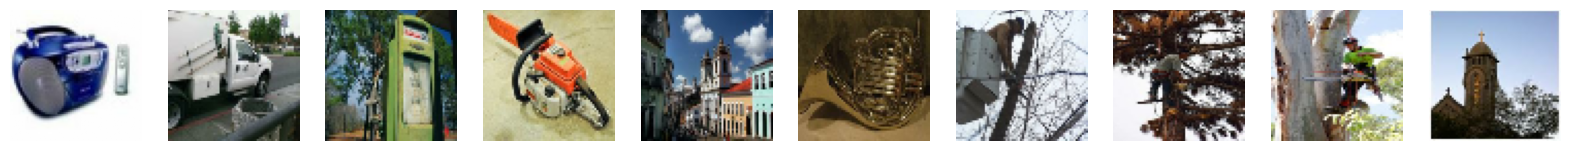

In [2]:
# simple resize function to shrink our images
def resize(image, label, size=[64, 64]):
    image = tf.image.resize(image, size)
    return (image,label)

# convert the contents of a tfds to a couple of numpy arrays
def convert_to_numpy(ds):
    
    x = []
    y = []

    # loop through the dataste
    for im,l in ds:
        # add the images and their labels to x and y lists
        x.append(im)
        y.append(l)

    # convert lists to arrays
    x = np.array(x)
    y = np.array(y)
    # convert the images to a float, and scale by 1/255
    x = (x.astype(np.float32) / 255.0)
    
    # return the newly converted x and y
    return x, y

# load a tdfs dataset, and convert it to numpy
def load_tfds(dataset):
    # load the data
    (ds_train, ds_test), ds_info = tfds.load(
        dataset,
        split=['train', 'validation'],
        shuffle_files=True,
        as_supervised=True,
        with_info=True,
    )

    # resize images. Important to help things run a bit faster, but images are 
    # also not of a uniform size, so we need to get all images to the same 
    # shape
    ds_train = ds_train.map(resize)
    ds_test = ds_test.map(resize)

    # convert to numpy
    x_train, y_train = convert_to_numpy(ds_train)
    x_test, y_test = convert_to_numpy(ds_test)

    # return the numpy version of the data
    return (x_train, y_train), (x_test, y_test)

# pictures, lots of pictures
def display_images(data, num_images):
    fig, ax = plt.subplots(nrows=1, ncols=num_images, figsize=(2*num_images, 2))
    for i in range(num_images):
        ax[i].imshow(data[i, :], cmap='gray')
        ax[i].axis('off')
    plt.show()

# load the data
(x_train, y_train), (x_test, y_test) = load_tfds('imagenette/160px-v2')

# display the first 10 images of the train and test sets
display_images(x_train, 10)

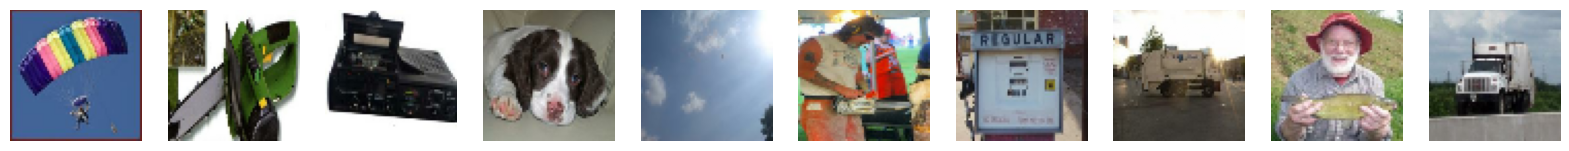

In [3]:
display_images(x_test, 10)

Vectorise data. For our random forest (and also for an SVM, or CKNN, or XGBoost, or anything of those methods) we need our data as a vector.

In [4]:
x_train_vec = x_train.reshape(-1, 64*64*3).astype('float32') / 255
x_test_vec = x_test.reshape(-1, 64*64*3).astype('float32') / 255

Train a simple random forest, just using the raw pixel data as an input.

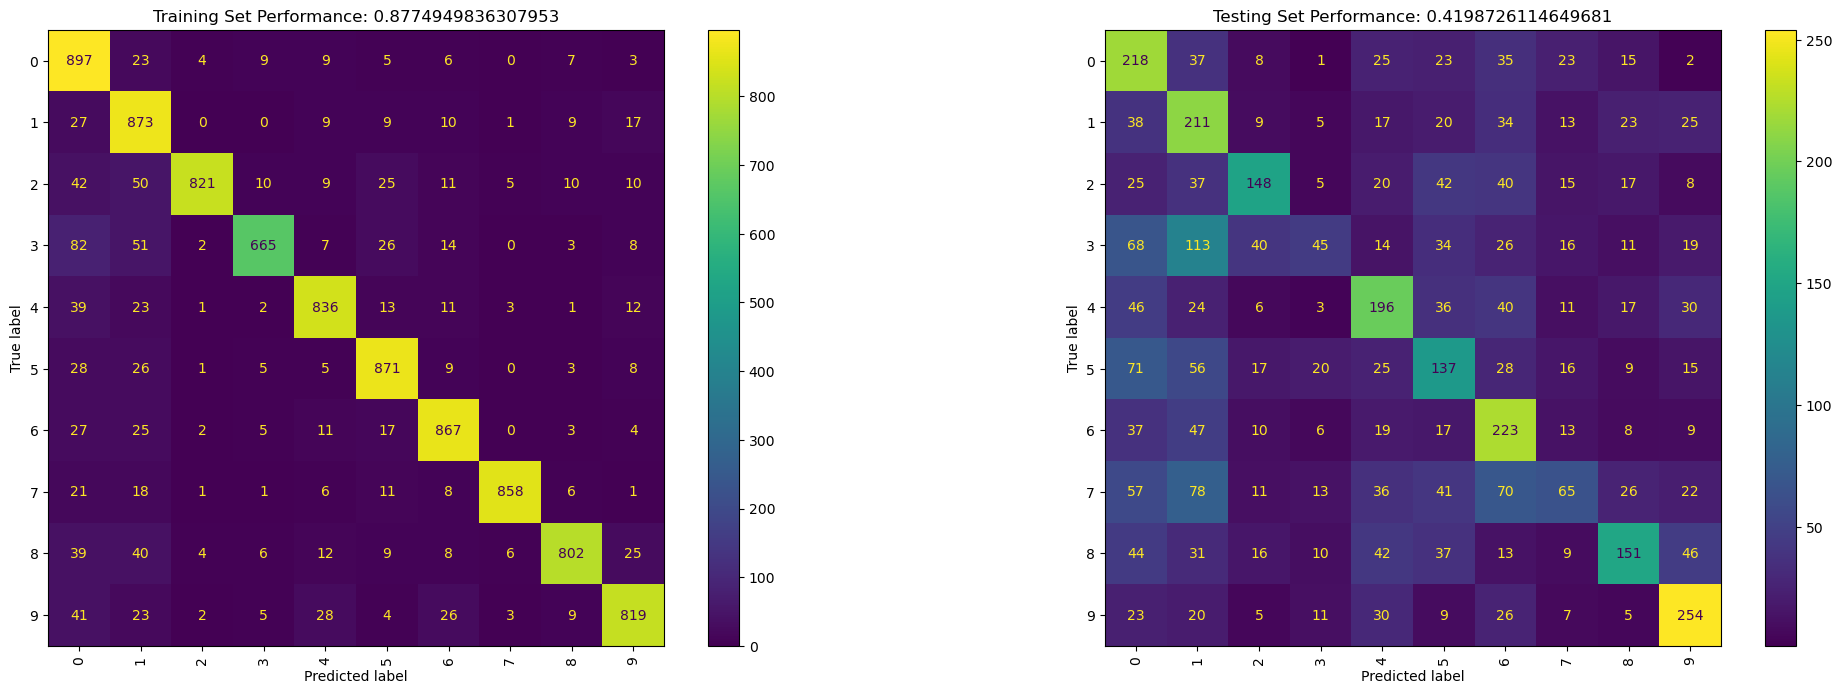

In [5]:
def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize=None, \
                                                 xticks_rotation='vertical', ax=ax)
    pred = model.predict(X_train)
    conf.ax_.set_title('Training Set Performance: ' + str(sum(pred == Y_train)/len(Y_train)));
    ax = fig.add_subplot(1, 2, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize=None, \
                                                 xticks_rotation='vertical', ax=ax)
    pred = model.predict(X_test)
    conf.ax_.set_title('Testing Set Performance: ' + str(sum(pred == Y_test)/len(Y_test)));

rf = RandomForestClassifier(n_estimators=250, max_depth=10, random_state=0).fit(x_train_vec, y_train)
eval_model(rf, x_train_vec, y_train, x_test_vec, y_test)

The performance above is nothing spectacular. The model struggles on most classes, and if you ran this code youself you'll notice it was quite slow.

For many types of data, with pre-deep learning methods the raw data (pixels in our case) is rarely a good representation. Often, we need to do some sort of feature extraction, which we can think of as a way of transforming our data. There are many, many, feature extraction methods, and we're not going to get into the weeds on these here, but one common method that generally works well is the Histogram of Orietated Gradients (HOG, see 02_Classification/CAB420_Classification_Bonus_Example_HOG.ipynb), which focusses on pulling out texture information (edge orientations in particular).

This feature extraction has a bunch of parameters itself, and can yield very different sized feature sets, with different levels of local detail.

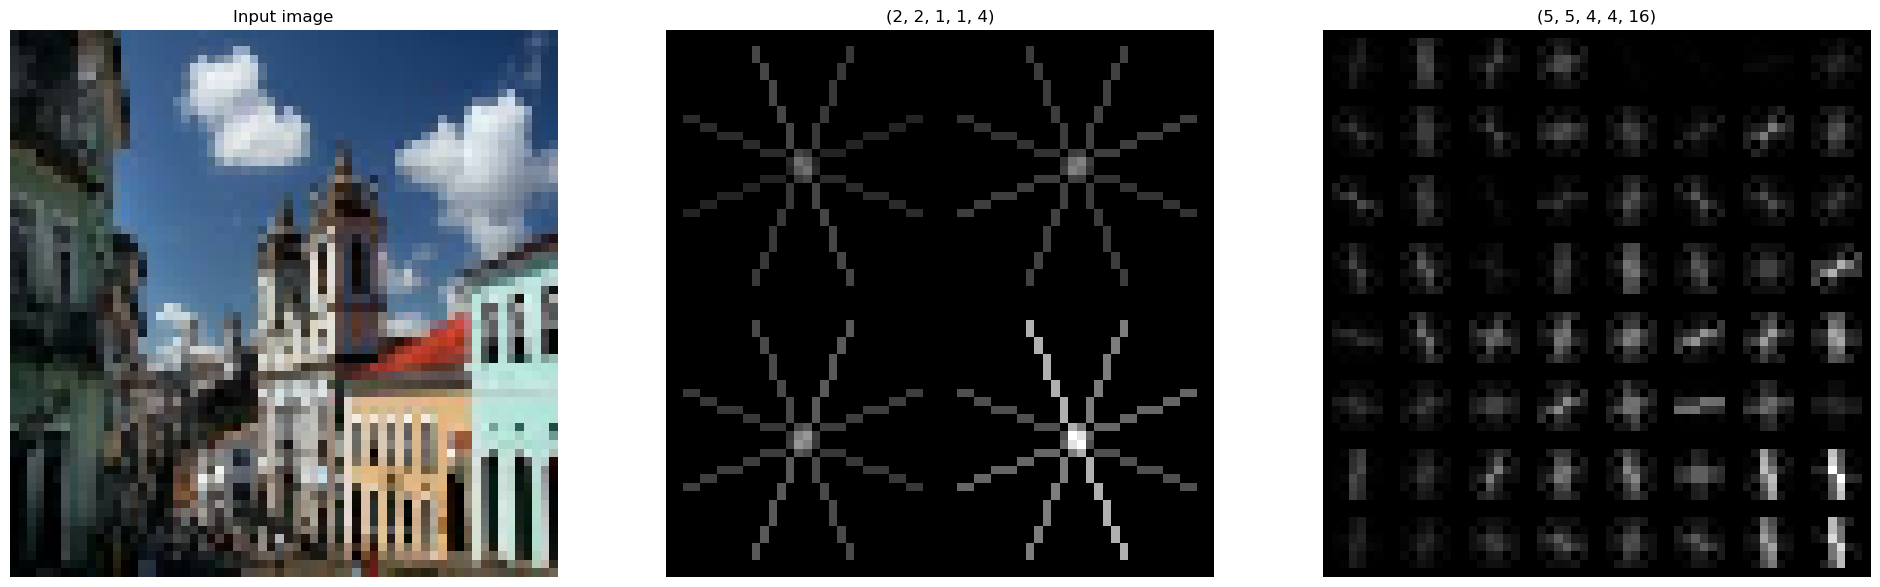

In [6]:
# coarse representation. Very large cells, few orientations.
fd_coarse, hog_image_coarse = hog(x_train[4,:,:,:], orientations=4, pixels_per_cell=(32, 32),
                    cells_per_block=(1, 1), visualize=True, channel_axis=2, feature_vector=False)
# fine representation. Smaller cells, more orientations.
fd_fine, hog_image_fine = hog(x_train[4,:,:,:], orientations=16, pixels_per_cell=(8, 8),
                    cells_per_block=(4, 4), visualize=True, channel_axis=2, feature_vector=False)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(x_train[4,:,:,:])
ax1.set_title('Input image')

ax2.axis('off')
ax2.imshow(exposure.rescale_intensity(hog_image_coarse, in_range=(0, 10)), cmap=plt.cm.gray)
ax2.set_title(fd_coarse.shape)

ax3.axis('off')
ax3.imshow(exposure.rescale_intensity(hog_image_fine, in_range=(0, 10)), cmap=plt.cm.gray)
ax3.set_title(fd_fine.shape)
plt.show()

Typically, what we'd do is transform our data with some feature extraction, and the pass the resultant feature through to our machine learning method.

For our simple random forest this might look like the following:

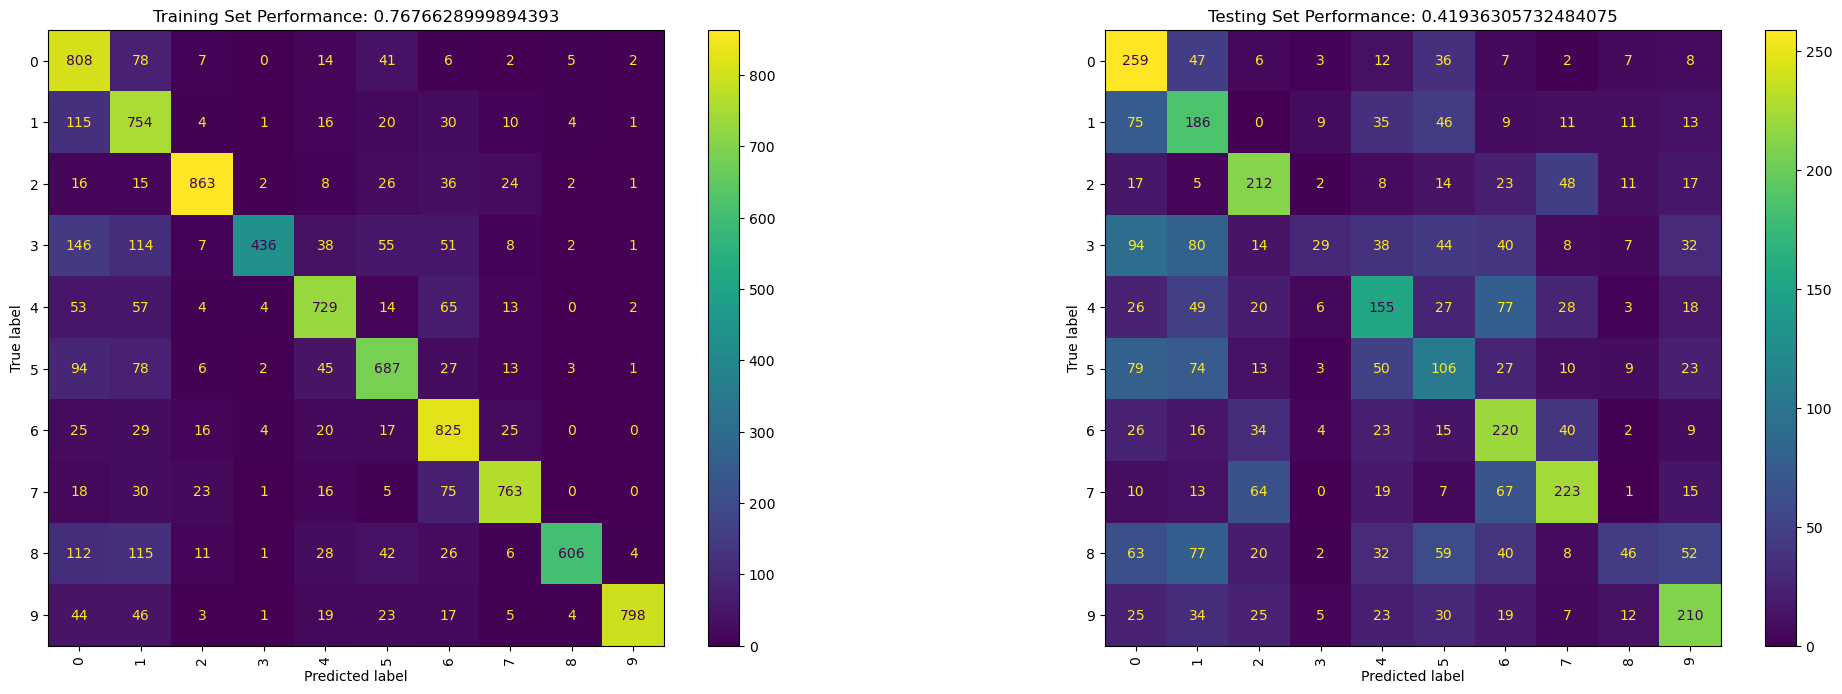

In [7]:
# transform function
def transform_datset_to_hog(data, orientations=16, pixels_per_cell=(24, 24), cells_per_block=(2, 2)):
    hog_data = []
    for im in range(data.shape[0]):
        hog_data.append(hog(data[im, :, :, :], orientations=orientations, pixels_per_cell=pixels_per_cell,
                            cells_per_block=cells_per_block, visualize=False, channel_axis=2, feature_vector=True))
    return np.array(hog_data)

# transform data to HOG. 
x_train_hog = transform_datset_to_hog(x_train)
x_test_hog = transform_datset_to_hog(x_test)

# Run the RF
hog_rf = RandomForestClassifier(n_estimators=250, max_depth=10, random_state=0).fit(x_train_hog, y_train)
eval_model(hog_rf, x_train_hog, y_train, x_test_hog, y_test)

This gives a ~6% gain in test accuracy - not bad - and with a feature representation that's about 1/50th the size (so much more efficient).

In [8]:
print(x_train_hog.shape)
print(x_train_vec.shape)

(9469, 64)
(9469, 12288)


But, we now have two sets of parameters we need to optimise - the parmeters of our feature extraction (including the choice of features) and the parameters of our machine learning model, and sub-optimal feature extraction parameters will end badly for us in terms of performance (see below). 

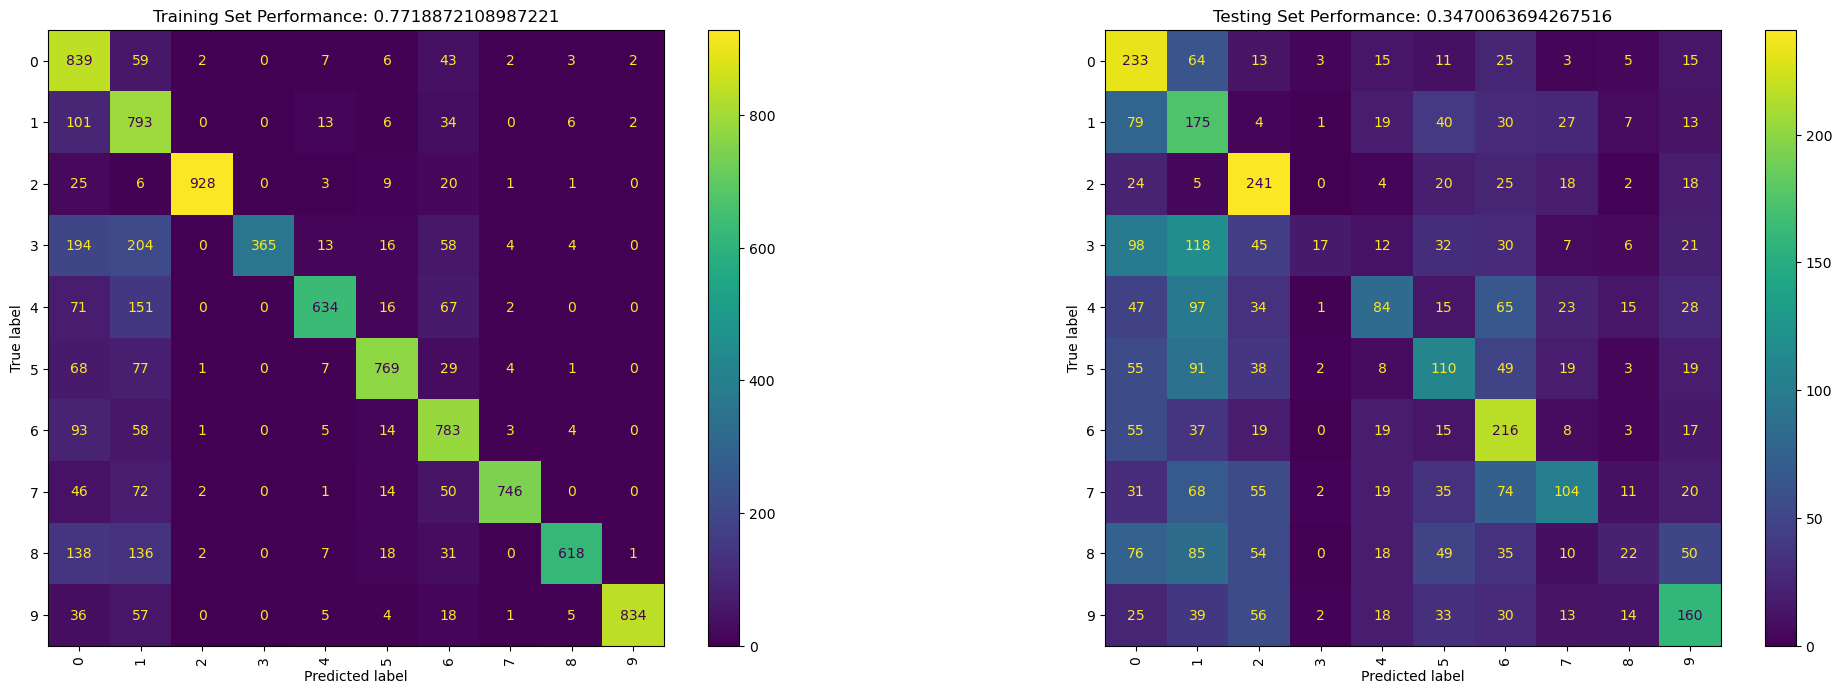

In [9]:
# transform data to HOG. 
x_train_hog = transform_datset_to_hog(x_train, orientations=4, pixels_per_cell=(8, 8), cells_per_block=(1, 1))
x_test_hog = transform_datset_to_hog(x_test, orientations=4, pixels_per_cell=(8, 8), cells_per_block=(1, 1))
# Run the RF
hog_rf = RandomForestClassifier(n_estimators=250, max_depth=10, random_state=0).fit(x_train_hog, y_train)
eval_model(hog_rf, x_train_hog, y_train, x_test_hog, y_test)

Further, as we change the parameters of our feature extraction, the optimal set of parameters for our machine learning algorithm will change (note that I've not attempted any grid searches in the above). 

For different datasets, and certainly for different data types, different feature extraction approaches will be optimal. Over time, with lots and lots of experience, you will start to develop a sense of what methods/parameters are appropraite in different settings, but this still will only provide a guide, so ultimatley there is a need to optimse across both the feature extraction parameters and model parameters jointly.

This feature extraction challenge is one of the big motivating factors for deep learning methods - these effectivley learn a set of feature from the data, and then learn to classify or regress from that representation in one pass. For signal data, such as images, this ability to learn a suitable representation directly from the data has led to huge performance gains. For the sake of a quick comparison, let's quickly train a simple DCNN on this data.

I0000 00:00:1738192922.283013   54908 service.cc:148] XLA service 0x7fdb4400e830 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738192922.283049   54908 service.cc:156]   StreamExecutor device (0): NVIDIA A16-4Q, Compute Capability 8.6
I0000 00:00:1738192922.457095   54908 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1738192926.800687   54908 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


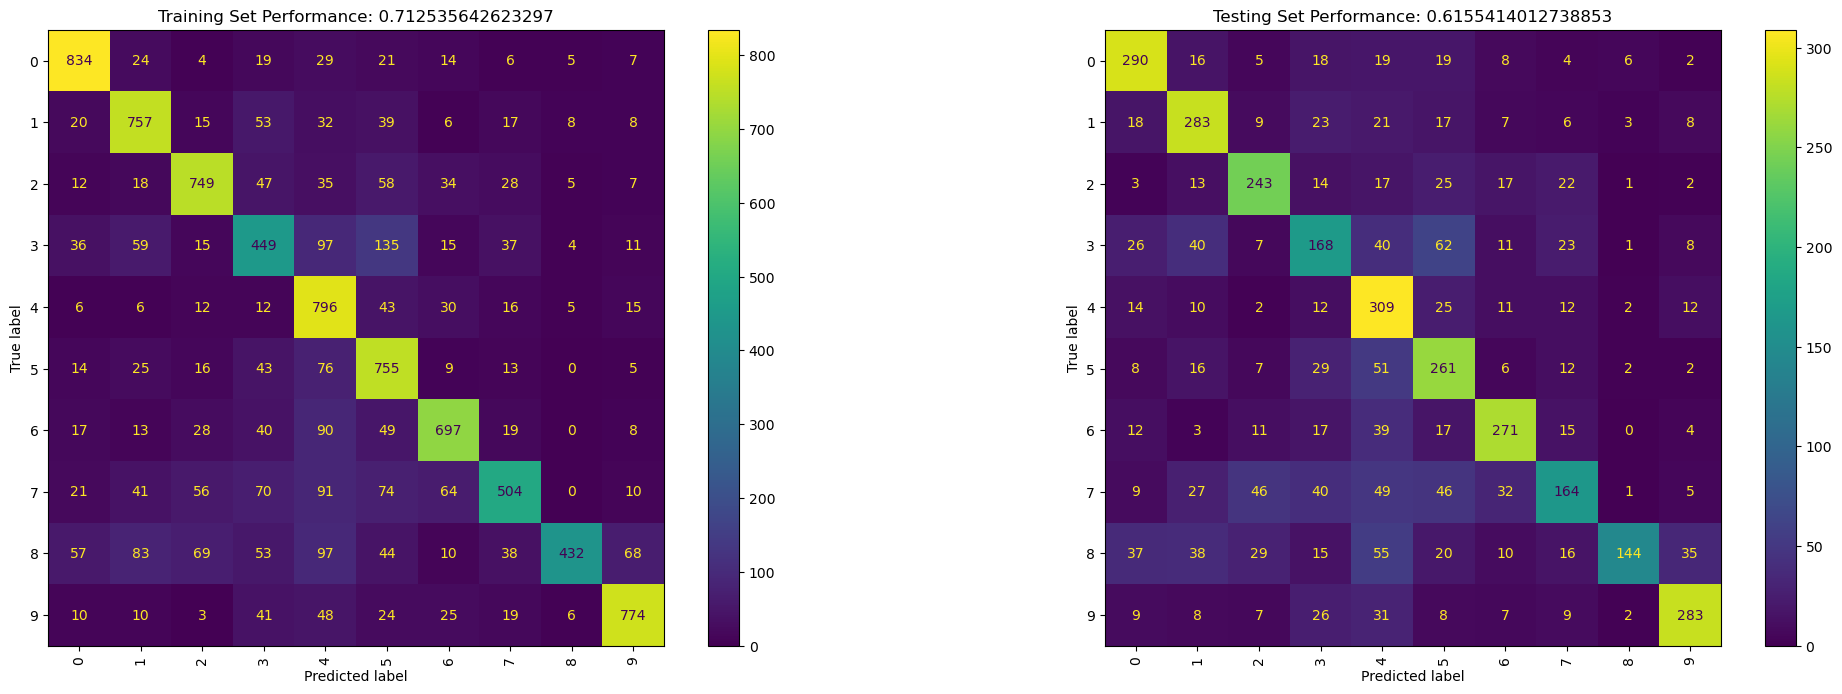

In [10]:
# our input now has a different shape, 28x28x1, as we have 28x28 single channel images
inputs = keras.Input(shape=(64, 64, 3, ), name='img')
# 2D conv, 8 filters
x = keras.layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(inputs)
# 2x2 max pooling, this will downsample the image by a factor of two
x = keras.layers.MaxPool2D(pool_size=(2, 2))(x)
# more convolution, 16 filters, followed by max poool
x = keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = keras.layers.MaxPool2D(pool_size=(2, 2))(x)
# more convolution, 32 filters, followed by max poool
x = keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = keras.layers.MaxPool2D(pool_size=(2, 2))(x)
# final convolution, another 32 filters, followed by max poool
x = keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = keras.layers.MaxPool2D(pool_size=(2, 2))(x)
# a flatten layer. 
x = keras.layers.Flatten()(x)
# some fully connected layaers
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dense(64, activation='relu')(x)
# and now our output, same as last time
outputs = keras.layers.Dense(10, activation='softmax')(x)

# build the model, and print the summary
model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='simple_cnn')

model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'], jit_compile=True)
history = model_cnn.fit(x_train, y_train, batch_size=64, epochs=30, validation_split=0.2, verbose=False, 
                        callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

def eval_model_dcnn(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    pred = model.predict(X_train, verbose=False, batch_size=64)
    pred = keras.ops.argmax(pred, axis=1).numpy()
    conf = ConfusionMatrixDisplay.from_predictions(Y_train, pred, normalize=None, \
                                                 xticks_rotation='vertical', ax=ax)
    conf.ax_.set_title('Training Set Performance: ' + str(sum(pred == Y_train)/len(Y_train)));
    ax = fig.add_subplot(1, 2, 2)
    pred = model.predict(X_test, verbose=False, batch_size=64)
    pred = keras.ops.argmax(pred, axis=1).numpy()
    conf = ConfusionMatrixDisplay.from_predictions(Y_test, pred, normalize=None, \
                                                 xticks_rotation='vertical', ax=ax)
    conf.ax_.set_title('Testing Set Performance: ' + str(sum(pred == Y_test)/len(Y_test)));

eval_model_dcnn(model_cnn, x_train, y_train, x_test, y_test)

Performance of our fairly simple DCNN far exceeds that of our HOG based methods; in part as we're now able to learn a feature representation from the data directly rather than needing to hand-craft it.

It's worth noting here that we could greatly improve the performance of all models in this example if we wished. Better tuning the feature exraction for our RFs would help and we could consider using multiple feature extraction methods there too. Similarly, we could do a lot more fancy things with our DCNN to make that better again - but that's all outside the scope of this little motivating example.